In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

## Initialization

In [ ]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)])

mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])

L = 32 # group size

cifar_trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                              download=True, transform=cifar_transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                             download=True, transform=cifar_transform)

mnist_trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                            download=True, transform=mnist_transform)
mnist_testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                           download=True, transform=mnist_transform)

#################################### To Do (2 pts) #############################
# Define trainloader and testloader with given batch size.
# Set shuffle parameter to True for trainloader and False for testloader.
################################################################################
cifar_trainLoader = torch.utils.data.DataLoader(cifar_trainset, batch_size = L, shuffle = True)
cifar_testLoader = torch.utils.data.DataLoader(cifar_testset, batch_size = L, shuffle = False)

mnist_trainLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size = L, shuffle = True)
mnist_testLoader = torch.utils.data.DataLoader(mnist_testset, batch_size = L, shuffle = False)
##################################### End ######################################

device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')

100%|██████████| 170498071/170498071 [00:01<00:00, 91581524.04it/s] 


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


100%|██████████| 9912422/9912422 [00:00<00:00, 83058563.02it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112162679.47it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23574036.10it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21972928.22it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = torch.softmax(x, dim=1)
        return output

## differentially private SGD

In [ ]:
criterion = nn.CrossEntropyLoss()
lr=0.001

In [ ]:
def DP_SGD(model, trainloader, criterion, lr, sigma, C):
  """
  sigma: noise scale
  C: gradient norm bound
  """
  #################################### To Do (16 pts) ##########################
  model.train()
  for batch in trainloader:
    for param in model.parameters():
        param.accumulated_grads = []

    # 1. For each sample, compute gradients of loss w.r.t. parameters (5 pts)
    datas, labels = batch
    for data , label in zip(datas, labels):
        data, label = data.to(device), label.to(device)
        model.zero_grad()
        output = model(data.unsqueeze(0))
        loss = criterion(output, label.unsqueeze(0))
        loss.backward()
    # 2. Clip each parameter's per-sample gradient (4 pts)
        grads = []
        for param in model.parameters():
            grads.append(param.grad)
        clip_grad_norm_(grads, C)

        for param, grad in zip(model.parameters(), grads):
                param.accumulated_grads.append(grad)
    # 3. Add noise and aggregate back accumulated grads with torch.stack (4 pts)
    for param in model.parameters():
        param.grad = torch.stack(param.accumulated_grads).mean(dim=0)
        param.grad += (torch.randn(param.grad.shape) * sigma * C/ datas.shape[0]).to(device)

    # 4. Update model's weights and reset grad for the next iteration (3 pts)
        param.data = param - lr * param.grad
        param.grad.zero_()
  ##################################### End ####################################

## Evaluation
Now, we want to test this algorithm on CIFAR10 and MNIST datasets.

In [ ]:
def train(model, trainloader, testloader, criterion, num_epochs, sigma, C):
  train_accuracy = []
  test_accuracy = []

  for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    total = 0

    # train model using DP-SGD algorithm
    DP_SGD(model, trainloader, criterion, lr, sigma, C)

    # Compute training accuracy
    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        train_correct += (predicted == target).sum().item()

        # Compute training loss
        loss = criterion(output, target)
        train_loss += loss.item()

    # Print training accuracy and loss for each epoch
    print('Epoch [{}/{}], Train Accuracy: {:.2f}%, Train Loss: {:.4f}'
          .format(epoch+1, num_epochs, 100*train_correct/total, train_loss/len(trainloader)))

    train_accuracy.append(train_correct/total)

    # Evaluate the model on the test dataset
    test_loss = 0.0
    test_correct = 0
    total = 0

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            test_correct += (predicted == target).sum().item()

            loss = criterion(output, target)
            test_loss += loss.item()

    # Print test accuracy and loss for each epoch
    print('Epoch [{}/{}], Test Accuracy: {:.2f}%, Test Loss: {:.4f}'
          .format(epoch+1, num_epochs, 100*test_correct/total, test_loss/len(testloader)))

    test_accuracy.append(test_correct/total)

  return train_accuracy, test_accuracy

### Effect of $\sigma$ (and $\epsilon$) (6 pts)
Plot accuracy vs. epoch for various noise scale $\sigma = 2, 4, 8$ for both datasets. Plot both training and testing accuracy.

Change the code above if needed.

In [ ]:
model = Net(3)
model.to(device)
sigma = 2
C = 4
num_epochs = 10
train_accuracy_2, test_accuracy_2 = train(model, cifar_trainLoader, cifar_testLoader, criterion, num_epochs, sigma, C)

Epoch [1/10], Train Accuracy: 10.46%, Train Loss: 2.3014
Epoch [1/10], Test Accuracy: 10.50%, Test Loss: 2.3014
Epoch [2/10], Train Accuracy: 12.79%, Train Loss: 2.2996
Epoch [2/10], Test Accuracy: 12.69%, Test Loss: 2.2995
Epoch [3/10], Train Accuracy: 12.83%, Train Loss: 2.2956
Epoch [3/10], Test Accuracy: 12.89%, Test Loss: 2.2953
Epoch [4/10], Train Accuracy: 11.38%, Train Loss: 2.2858
Epoch [4/10], Test Accuracy: 11.37%, Test Loss: 2.2852
Epoch [5/10], Train Accuracy: 14.57%, Train Loss: 2.2761
Epoch [5/10], Test Accuracy: 14.52%, Test Loss: 2.2750
Epoch [6/10], Train Accuracy: 17.43%, Train Loss: 2.2650
Epoch [6/10], Test Accuracy: 17.18%, Test Loss: 2.2636
Epoch [7/10], Train Accuracy: 20.75%, Train Loss: 2.2484
Epoch [7/10], Test Accuracy: 20.50%, Test Loss: 2.2470
Epoch [8/10], Train Accuracy: 24.66%, Train Loss: 2.2285
Epoch [8/10], Test Accuracy: 24.66%, Test Loss: 2.2274
Epoch [9/10], Train Accuracy: 26.81%, Train Loss: 2.2060
Epoch [9/10], Test Accuracy: 27.27%, Test Loss:

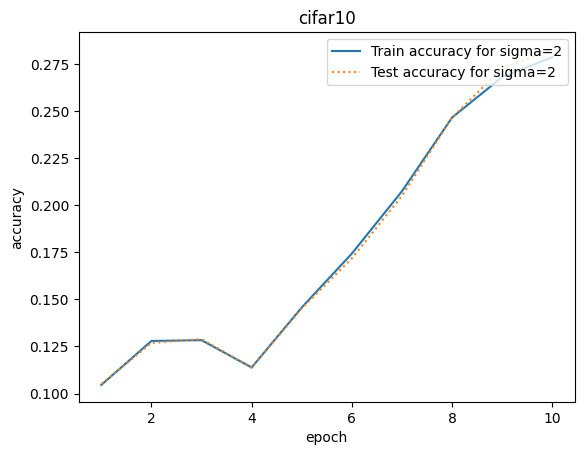

In [ ]:
epochs = list(range(1, 10+1))
plt.plot(epochs, train_accuracy_2, ls="-", label=f"Train accuracy for sigma=2")
plt.plot(epochs, test_accuracy_2, ls=":", label=f"Test accuracy for sigma=2")

plt.legend(loc='upper right')
plt.title('cifar10')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model = Net(1)
model.to(device)
sigma = 2
C = 4
num_epochs = 10
train_accuracy_2, test_accuracy_2 = train(model, mnist_trainLoader, mnist_testLoader, criterion, num_epochs, sigma, C)

Epoch [1/10], Train Accuracy: 40.45%, Train Loss: 2.2212
Epoch [1/10], Test Accuracy: 40.58%, Test Loss: 2.2212
Epoch [2/10], Train Accuracy: 68.60%, Train Loss: 1.8465
Epoch [2/10], Test Accuracy: 68.66%, Test Loss: 1.8433
Epoch [3/10], Train Accuracy: 81.42%, Train Loss: 1.6790
Epoch [3/10], Test Accuracy: 82.28%, Test Loss: 1.6708
Epoch [4/10], Train Accuracy: 82.72%, Train Loss: 1.6509
Epoch [4/10], Test Accuracy: 83.56%, Test Loss: 1.6431
Epoch [5/10], Train Accuracy: 83.18%, Train Loss: 1.6400
Epoch [5/10], Test Accuracy: 83.92%, Test Loss: 1.6335
Epoch [6/10], Train Accuracy: 83.74%, Train Loss: 1.6326
Epoch [6/10], Test Accuracy: 84.35%, Test Loss: 1.6265
Epoch [7/10], Train Accuracy: 83.92%, Train Loss: 1.6292
Epoch [7/10], Test Accuracy: 84.42%, Test Loss: 1.6231
Epoch [8/10], Train Accuracy: 84.08%, Train Loss: 1.6273
Epoch [8/10], Test Accuracy: 84.62%, Test Loss: 1.6216
Epoch [9/10], Train Accuracy: 84.39%, Train Loss: 1.6222
Epoch [9/10], Test Accuracy: 85.02%, Test Loss:

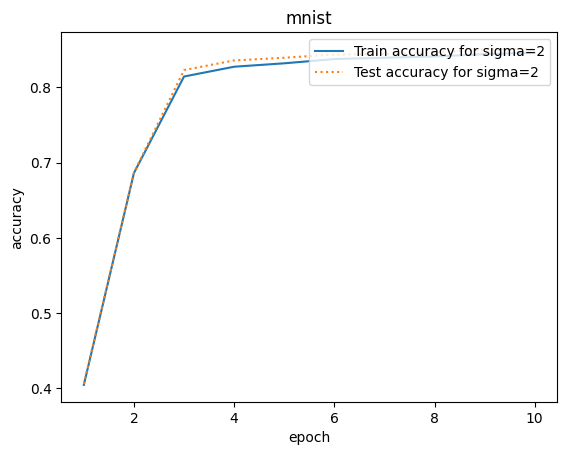

In [ ]:
epochs = list(range(1, 10+1))
plt.plot(epochs, train_accuracy_2, ls="-", label=f"Train accuracy for sigma=2")
plt.plot(epochs, test_accuracy_2, ls=":", label=f"Test accuracy for sigma=2")

plt.legend(loc='upper right')
plt.title('mnist')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model = Net(3)
model.to(device)
sigma = 4
C = 4
num_epochs = 15
train_accuracy_4, test_accuracy_4 = train(model, cifar_trainLoader, cifar_testLoader, criterion, num_epochs, sigma, C)

Epoch [1/15], Train Accuracy: 10.53%, Train Loss: 2.3017
Epoch [1/15], Test Accuracy: 10.74%, Test Loss: 2.3016
Epoch [2/15], Train Accuracy: 10.85%, Train Loss: 2.3005
Epoch [2/15], Test Accuracy: 10.84%, Test Loss: 2.3003
Epoch [3/15], Train Accuracy: 12.26%, Train Loss: 2.2988
Epoch [3/15], Test Accuracy: 12.44%, Test Loss: 2.2985
Epoch [4/15], Train Accuracy: 13.04%, Train Loss: 2.2964
Epoch [4/15], Test Accuracy: 13.23%, Test Loss: 2.2961
Epoch [5/15], Train Accuracy: 14.49%, Train Loss: 2.2847
Epoch [5/15], Test Accuracy: 14.78%, Test Loss: 2.2835
Epoch [6/15], Train Accuracy: 18.88%, Train Loss: 2.2645
Epoch [6/15], Test Accuracy: 19.41%, Test Loss: 2.2627
Epoch [7/15], Train Accuracy: 21.87%, Train Loss: 2.2437
Epoch [7/15], Test Accuracy: 22.70%, Test Loss: 2.2413
Epoch [8/15], Train Accuracy: 24.77%, Train Loss: 2.2167
Epoch [8/15], Test Accuracy: 25.01%, Test Loss: 2.2143
Epoch [9/15], Train Accuracy: 26.02%, Train Loss: 2.2009
Epoch [9/15], Test Accuracy: 26.34%, Test Loss:

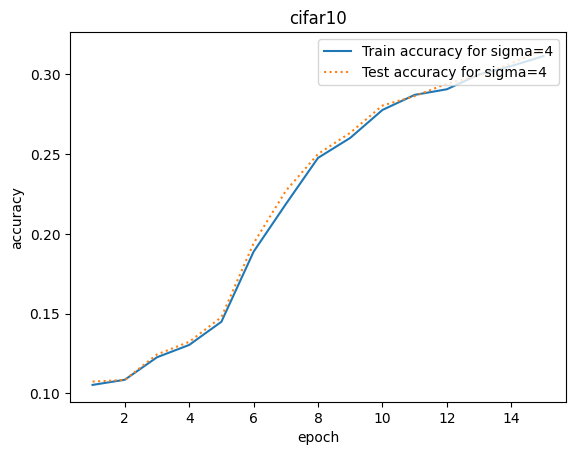

In [ ]:
epochs = list(range(1, 15+1))
plt.plot(epochs, train_accuracy_4, ls="-", label=f"Train accuracy for sigma=4")
plt.plot(epochs, test_accuracy_4, ls=":", label=f"Test accuracy for sigma=4")

plt.legend(loc='upper right')
plt.title('cifar10')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model = Net(1)
model.to(device)
sigma = 4
C = 4
num_epochs = 15
train_accuracy_4, test_accuracy_4 = train(model, mnist_trainLoader, mnist_testLoader, criterion, num_epochs, sigma, C)

Epoch [1/15], Train Accuracy: 19.27%, Train Loss: 2.2852
Epoch [1/15], Test Accuracy: 18.29%, Test Loss: 2.2851
Epoch [2/15], Train Accuracy: 54.09%, Train Loss: 1.9852
Epoch [2/15], Test Accuracy: 54.81%, Test Loss: 1.9808
Epoch [3/15], Train Accuracy: 82.58%, Train Loss: 1.6920
Epoch [3/15], Test Accuracy: 83.61%, Test Loss: 1.6828
Epoch [4/15], Train Accuracy: 87.76%, Train Loss: 1.6095
Epoch [4/15], Test Accuracy: 88.37%, Test Loss: 1.6025
Epoch [5/15], Train Accuracy: 88.99%, Train Loss: 1.5858
Epoch [5/15], Test Accuracy: 89.59%, Test Loss: 1.5800
Epoch [6/15], Train Accuracy: 89.29%, Train Loss: 1.5773
Epoch [6/15], Test Accuracy: 89.92%, Test Loss: 1.5718
Epoch [7/15], Train Accuracy: 89.66%, Train Loss: 1.5725
Epoch [7/15], Test Accuracy: 90.01%, Test Loss: 1.5675
Epoch [8/15], Train Accuracy: 89.94%, Train Loss: 1.5679
Epoch [8/15], Test Accuracy: 90.26%, Test Loss: 1.5635
Epoch [9/15], Train Accuracy: 90.10%, Train Loss: 1.5646
Epoch [9/15], Test Accuracy: 90.48%, Test Loss:

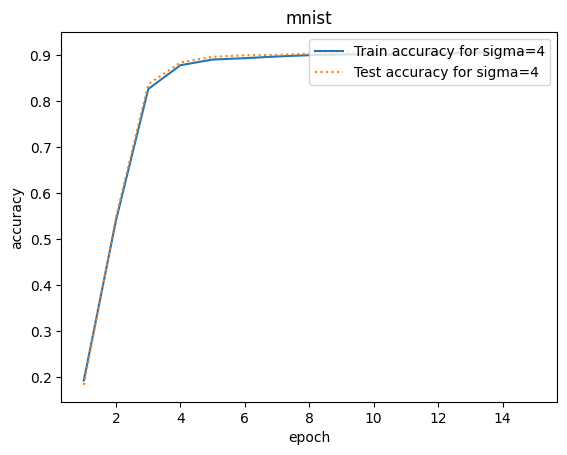

In [ ]:
epochs = list(range(1, 15+1))
plt.plot(epochs, train_accuracy_4, ls="-", label=f"Train accuracy for sigma=4")
plt.plot(epochs, test_accuracy_4, ls=":", label=f"Test accuracy for sigma=4")

plt.legend(loc='upper right')
plt.title('mnist')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model = Net(3)
model.to(device)
sigma = 8
C = 4
num_epochs = 20
train_accuracy_8, test_accuracy_8 = train(model, cifar_trainLoader, cifar_testLoader, criterion, num_epochs, sigma, C)

Epoch [1/20], Train Accuracy: 12.52%, Train Loss: 2.3009
Epoch [1/20], Test Accuracy: 12.64%, Test Loss: 2.3008
Epoch [2/20], Train Accuracy: 13.63%, Train Loss: 2.2955
Epoch [2/20], Test Accuracy: 13.74%, Test Loss: 2.2953
Epoch [3/20], Train Accuracy: 18.50%, Train Loss: 2.2734
Epoch [3/20], Test Accuracy: 18.18%, Test Loss: 2.2726
Epoch [4/20], Train Accuracy: 22.24%, Train Loss: 2.2350
Epoch [4/20], Test Accuracy: 22.19%, Test Loss: 2.2337
Epoch [5/20], Train Accuracy: 22.99%, Train Loss: 2.2201
Epoch [5/20], Test Accuracy: 23.15%, Test Loss: 2.2188
Epoch [6/20], Train Accuracy: 24.03%, Train Loss: 2.2100
Epoch [6/20], Test Accuracy: 24.30%, Test Loss: 2.2097
Epoch [7/20], Train Accuracy: 24.56%, Train Loss: 2.2037
Epoch [7/20], Test Accuracy: 24.19%, Test Loss: 2.2061
Epoch [8/20], Train Accuracy: 26.32%, Train Loss: 2.1895
Epoch [8/20], Test Accuracy: 26.78%, Test Loss: 2.1856
Epoch [9/20], Train Accuracy: 27.01%, Train Loss: 2.1823
Epoch [9/20], Test Accuracy: 27.40%, Test Loss:

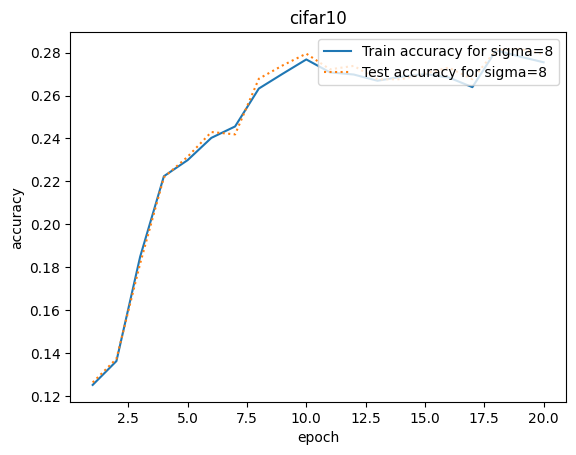

In [ ]:
epochs = list(range(1, 20+1))
plt.plot(epochs, train_accuracy_8, ls="-", label=f"Train accuracy for sigma=8")
plt.plot(epochs, test_accuracy_8, ls=":", label=f"Test accuracy for sigma=8")

plt.legend(loc='upper right')
plt.title('cifar10')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model = Net(1)
model.to(device)
sigma = 8
C = 4
num_epochs = 20
train_accuracy_8, test_accuracy_8 = train(model, mnist_trainLoader, mnist_testLoader, criterion, num_epochs, sigma, C)

Epoch [1/20], Train Accuracy: 36.21%, Train Loss: 2.1165
Epoch [1/20], Test Accuracy: 35.92%, Test Loss: 2.1131
Epoch [2/20], Train Accuracy: 71.62%, Train Loss: 1.7841
Epoch [2/20], Test Accuracy: 72.43%, Test Loss: 1.7758
Epoch [3/20], Train Accuracy: 76.02%, Train Loss: 1.7139
Epoch [3/20], Test Accuracy: 76.71%, Test Loss: 1.7063
Epoch [4/20], Train Accuracy: 75.15%, Train Loss: 1.7146
Epoch [4/20], Test Accuracy: 75.51%, Test Loss: 1.7085
Epoch [5/20], Train Accuracy: 75.44%, Train Loss: 1.7079
Epoch [5/20], Test Accuracy: 76.93%, Test Loss: 1.6953
Epoch [6/20], Train Accuracy: 75.38%, Train Loss: 1.7079
Epoch [6/20], Test Accuracy: 76.14%, Test Loss: 1.6983
Epoch [7/20], Train Accuracy: 76.92%, Train Loss: 1.6921
Epoch [7/20], Test Accuracy: 77.80%, Test Loss: 1.6835
Epoch [8/20], Train Accuracy: 76.99%, Train Loss: 1.6905
Epoch [8/20], Test Accuracy: 77.50%, Test Loss: 1.6856
Epoch [9/20], Train Accuracy: 77.26%, Train Loss: 1.6876
Epoch [9/20], Test Accuracy: 77.81%, Test Loss:

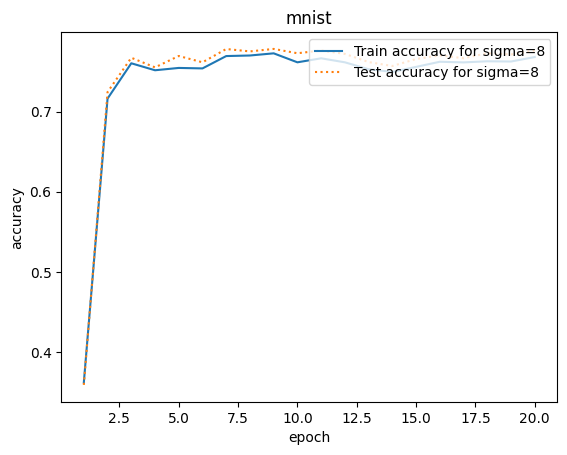

In [ ]:
epochs = list(range(1, 20+1))
plt.plot(epochs, train_accuracy_8, ls="-", label=f"Train accuracy for sigma=8")
plt.plot(epochs, test_accuracy_8, ls=":", label=f"Test accuracy for sigma=8")

plt.legend(loc='upper right')
plt.title('mnist')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

### Effect of $\epsilon, \delta$ (6 pts)
Plot accuracy vs. $\epsilon$ (according to formulas in the lectures) in range $(10^{-1}, 10)$ for $\delta=10^{-i}, i\in\{2, 3, 4, 5\}$ for both datasets.

In [ ]:
import numpy as np

def get_sigma(eps, delta):
  return np.sqrt(2 * np.log(1.25/delta)) / eps

train_accuracies = []
test_accuracies = []

for eps in np.linspace(0.1, 1, 5):
  for delta in [1e-2, 1e-3, 1e-4, 1e-5]:
    model = Net(3)
    model.to(device)
    C = 4
    sigma = get_sigma(eps, delta)
    num_epochs = 5
    print(f'\n------------------------- Training on eps = {eps}, delta = {delta} => sigma = {sigma} -------------------------')
    train_accuracy, test_accuracy = train(model, cifar_trainLoader, cifar_testLoader, criterion, num_epochs, sigma, C)
    train_accuracies.append(train_accuracy[-1])
    test_accuracies.append(test_accuracy[-1])


------------------------- Training on eps = 0.1, delta = 0.01 => sigma = 31.075114600922394 -------------------------
Epoch [1/5], Train Accuracy: 11.36%, Train Loss: 2.3384
Epoch [1/5], Test Accuracy: 11.18%, Test Loss: 2.3399
Epoch [2/5], Train Accuracy: 13.61%, Train Loss: 2.3226
Epoch [2/5], Test Accuracy: 13.45%, Test Loss: 2.3239
Epoch [3/5], Train Accuracy: 14.23%, Train Loss: 2.3178
Epoch [3/5], Test Accuracy: 14.54%, Test Loss: 2.3146
Epoch [4/5], Train Accuracy: 11.50%, Train Loss: 2.3454
Epoch [4/5], Test Accuracy: 11.57%, Test Loss: 2.3452
Epoch [5/5], Train Accuracy: 11.61%, Train Loss: 2.3444
Epoch [5/5], Test Accuracy: 11.52%, Test Loss: 2.3453

------------------------- Training on eps = 0.1, delta = 0.001 => sigma = 37.764795326590466 -------------------------
Epoch [1/5], Train Accuracy: 10.61%, Train Loss: 2.3512
Epoch [1/5], Test Accuracy: 10.33%, Test Loss: 2.3531
Epoch [2/5], Train Accuracy: 10.86%, Train Loss: 2.3513
Epoch [2/5], Test Accuracy: 10.64%, Test Loss

In [ ]:
import numpy as np

def get_sigma(eps, delta):
  return np.sqrt(2 * np.log(1.25/delta)) / eps

train_accuracies = []
test_accuracies = []

for eps in np.linspace(0.1, 1, 5):
  for delta in [1e-2, 1e-3, 1e-4, 1e-5]:
    model = Net(1)
    model.to(device)
    C = 4
    sigma = get_sigma(eps, delta)
    num_epochs = 5
    print(f'\n------------------------- Training on eps = {eps}, delta = {delta} => sigma = {sigma} -------------------------')
    train_accuracy, test_accuracy = train(model, mnist_trainLoader, mnist_testLoader, criterion, num_epochs, sigma, C)
    train_accuracies.append(train_accuracy[-1])
    test_accuracies.append(test_accuracy[-1])


------------------------- Training on eps = 0.1, delta = 0.01 => sigma = 31.075114600922394 -------------------------
Epoch [1/5], Train Accuracy: 20.40%, Train Loss: 2.2533
Epoch [1/5], Test Accuracy: 20.93%, Test Loss: 2.2480
Epoch [2/5], Train Accuracy: 12.85%, Train Loss: 2.3312
Epoch [2/5], Test Accuracy: 13.04%, Test Loss: 2.3296
Epoch [3/5], Train Accuracy: 17.72%, Train Loss: 2.2835
Epoch [3/5], Test Accuracy: 17.88%, Test Loss: 2.2823
Epoch [4/5], Train Accuracy: 22.75%, Train Loss: 2.2335
Epoch [4/5], Test Accuracy: 22.47%, Test Loss: 2.2362
Epoch [5/5], Train Accuracy: 25.05%, Train Loss: 2.2105
Epoch [5/5], Test Accuracy: 25.42%, Test Loss: 2.2069

------------------------- Training on eps = 0.1, delta = 0.001 => sigma = 37.764795326590466 -------------------------
Epoch [1/5], Train Accuracy: 23.90%, Train Loss: 2.2207
Epoch [1/5], Test Accuracy: 23.80%, Test Loss: 2.2209
Epoch [2/5], Train Accuracy: 28.67%, Train Loss: 2.1738
Epoch [2/5], Test Accuracy: 28.78%, Test Loss

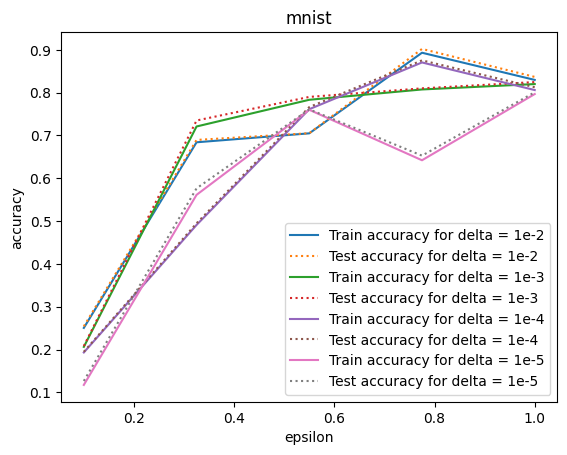

In [ ]:
plt.plot(np.linspace(0.1, 1, 5), train_accuracy_delta_2, ls="-", label=f"Train accuracy for delta = 1e-2")
plt.plot(np.linspace(0.1, 1, 5), test_accuracy_delta_2, ls=":", label=f"Test accuracy for delta = 1e-2")

plt.plot(np.linspace(0.1, 1, 5), train_accuracy_delta_3, ls="-", label=f"Train accuracy for delta = 1e-3")
plt.plot(np.linspace(0.1, 1, 5), test_accuracy_delta_3, ls=":", label=f"Test accuracy for delta = 1e-3")

plt.plot(np.linspace(0.1, 1, 5), train_accuracy_delta_4, ls="-", label=f"Train accuracy for delta = 1e-4")
plt.plot(np.linspace(0.1, 1, 5), test_accuracy_delta_4, ls=":", label=f"Test accuracy for delta = 1e-4")

plt.plot(np.linspace(0.1, 1, 5), train_accuracy_delta_5, ls="-", label=f"Train accuracy for delta = 1e-5")
plt.plot(np.linspace(0.1, 1, 5), test_accuracy_delta_5, ls=":", label=f"Test accuracy for delta = 1e-5")

plt.legend(loc='lower right')
plt.title('mnist')
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.show()

### Effect of clipping bound (3 pts)
Plot train and test accuracy vs. $C=1, 2, ..., 10$ for both datasets.

In [ ]:
train_accuracies = []
test_accuracies = []

for C in range(1,11):
  model = Net(3)
  model.to(device)
  sigma = 2
  num_epochs = 10
  print(f'\n----------------------------- Training on C = {C} -----------------------------')
  train_accuracy, test_accuracy = train(model, cifar_trainLoader, cifar_testLoader, criterion, num_epochs, sigma, C)
  train_accuracies.append(train_accuracy[-1])
  test_accuracies.append(test_accuracy[-1])


----------------------------- Training on C = 1 -----------------------------
Epoch [1/10], Train Accuracy: 13.68%, Train Loss: 2.3019
Epoch [1/10], Test Accuracy: 13.48%, Test Loss: 2.3019
Epoch [2/10], Train Accuracy: 16.27%, Train Loss: 2.3013
Epoch [2/10], Test Accuracy: 15.95%, Test Loss: 2.3012
Epoch [3/10], Train Accuracy: 16.52%, Train Loss: 2.3004
Epoch [3/10], Test Accuracy: 16.82%, Test Loss: 2.3004
Epoch [4/10], Train Accuracy: 16.15%, Train Loss: 2.2994
Epoch [4/10], Test Accuracy: 16.12%, Test Loss: 2.2994
Epoch [5/10], Train Accuracy: 17.04%, Train Loss: 2.2980
Epoch [5/10], Test Accuracy: 17.04%, Test Loss: 2.2979
Epoch [6/10], Train Accuracy: 17.19%, Train Loss: 2.2955
Epoch [6/10], Test Accuracy: 17.14%, Test Loss: 2.2953
Epoch [7/10], Train Accuracy: 16.88%, Train Loss: 2.2916
Epoch [7/10], Test Accuracy: 16.73%, Test Loss: 2.2914
Epoch [8/10], Train Accuracy: 15.72%, Train Loss: 2.2845
Epoch [8/10], Test Accuracy: 15.41%, Test Loss: 2.2840
Epoch [9/10], Train Accur

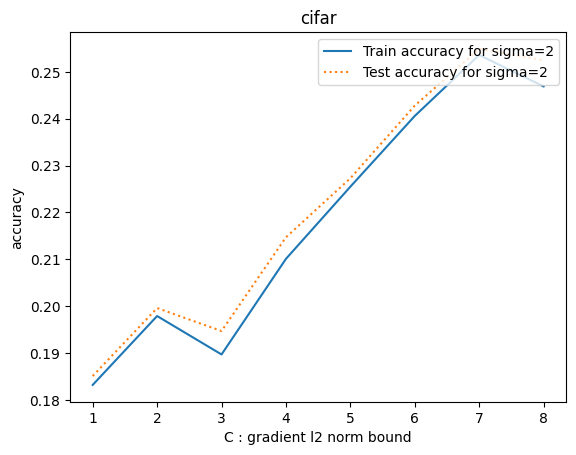

In [ ]:
import matplotlib.pyplot as plt
C_list = list(range(1, 9))
plt.plot(C_list, train_accuracies, ls="-", label=f"Train accuracy for sigma=2")
plt.plot(C_list, test_accuracies, ls=":", label=f"Test accuracy for sigma=2")

plt.legend(loc='upper right')
plt.title('cifar')
plt.xlabel("C : gradient l2 norm bound")
plt.ylabel("accuracy")
plt.show()

In [ ]:
train_accuracies = []
test_accuracies = []

for C in range(1,11):
  model = Net(1)
  model.to(device)
  sigma = 2
  num_epochs = 10
  print(f'\n----------------------------- Training on C = {C} -----------------------------')
  train_accuracy, test_accuracy = train(model, mnist_trainLoader, mnist_testLoader, criterion, num_epochs, sigma, C)
  train_accuracies.append(train_accuracy[-1])
  test_accuracies.append(test_accuracy[-1])


----------------------------- Training on C = 1 -----------------------------
Epoch [1/10], Train Accuracy: 57.26%, Train Loss: 2.2528
Epoch [1/10], Test Accuracy: 58.69%, Test Loss: 2.2520
Epoch [2/10], Train Accuracy: 78.63%, Train Loss: 1.7655
Epoch [2/10], Test Accuracy: 79.85%, Test Loss: 1.7568
Epoch [3/10], Train Accuracy: 88.36%, Train Loss: 1.6166
Epoch [3/10], Test Accuracy: 89.37%, Test Loss: 1.6075
Epoch [4/10], Train Accuracy: 89.75%, Train Loss: 1.5853
Epoch [4/10], Test Accuracy: 90.61%, Test Loss: 1.5772
Epoch [5/10], Train Accuracy: 90.40%, Train Loss: 1.5730
Epoch [5/10], Test Accuracy: 91.12%, Test Loss: 1.5659
Epoch [6/10], Train Accuracy: 90.84%, Train Loss: 1.5649
Epoch [6/10], Test Accuracy: 91.59%, Test Loss: 1.5575
Epoch [7/10], Train Accuracy: 91.43%, Train Loss: 1.5579
Epoch [7/10], Test Accuracy: 91.97%, Test Loss: 1.5512
Epoch [8/10], Train Accuracy: 91.80%, Train Loss: 1.5531
Epoch [8/10], Test Accuracy: 92.21%, Test Loss: 1.5470
Epoch [9/10], Train Accur

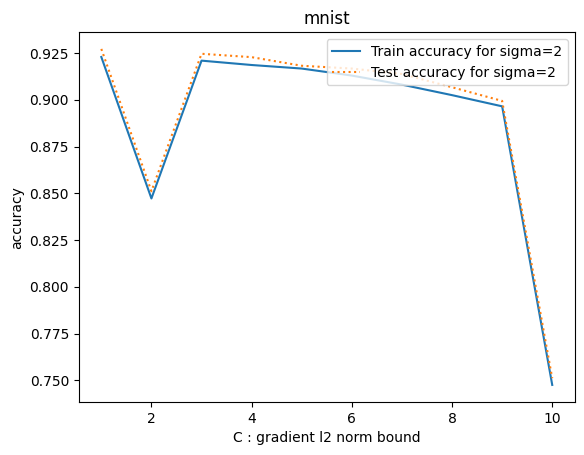

In [ ]:
C_list = list(range(1, 11))
plt.plot(C_list, train_accuracies, ls="-", label=f"Train accuracy for sigma=2")
plt.plot(C_list, test_accuracies, ls=":", label=f"Test accuracy for sigma=2")

plt.legend(loc='upper right')
plt.title('mnist')
plt.xlabel("C : gradient l2 norm bound")
plt.ylabel("accuracy")
plt.show()